In [119]:
import scipy.io as sio
test = sio.loadmat('data/example1kinect.mat')
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math
#from linearleastsquare import LinearLeastSqaureModel

In [109]:

amplitude_image = test['amplitudes1']

distance_image = test['distances1']

point_cloud = test['cloud1']

In [121]:
point_cloud

array([[[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.13569915, -0.88586158,  1.51099968],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.20425951, -0.9299584 ,  1.60499978],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       ...,

       [[-0.        ,  0.        ,  0.        ],
        [-0

In [111]:
test['amplitudes1']

array([[    0,  1711,  2618, ..., 11774, 17148,     0],
       [    0,  3487,  3862, ...,  6204,  6588,     0],
       [    0,  2883,  1739, ...,  6702,  7729,     0],
       ...,
       [    0,  9210,  7708, ...,  4909,  4566,     0],
       [    0, 17712, 13374, ...,  9831,  7632,     0],
       [    0, 33642, 16712, ...,  6590,  7424,     0]], dtype=uint16)

In [159]:
def visualise_box(test):
    plt.imshow(test)
    plt.show()

surface Detection

In [112]:
def ransac_floor_detection(point_cloud, threshold, max_iterations):
    # Your RANSAC implementation here
    best_floor_model = None
    best_floor_inliers = []

    for iteration in range(max_iterations):
        # Randomly sample points from the point cloud (you may need to customize this)
        sample = [random.choice(point_cloud) for _ in range(3)]
        print('sample: ', sample)
        #sample = random.sample(point_cloud, 2)  # Example: Randomly select 3 points for plane estimation

        # Fit a plane model to the sampled points (you need to implement fit_plane)
        floor_model = fit_plane(sample)

        # Calculate inliers using the fitted model and threshold (you need to implement calculate_inliers)
        inliers = calculate_inliers(point_cloud, floor_model, threshold)

        # If this model has more inliers, update the best model
        if len(inliers) > len(best_floor_inliers):
            best_floor_model = floor_model
            best_floor_inliers = inliers

    # Refine the best model using all inliers (optional)

    return best_floor_model, best_floor_inliers

In [154]:
import random

import numpy as np


class Plane:
    """
    Implementation of planar RANSAC.

    Class for Plane object, which finds the equation of a infinite plane using RANSAC algorithim.

    Call `fit(.)` to randomly take 3 points of pointcloud to verify inliers based on a threshold.

    ![Plane](https://raw.githubusercontent.com/leomariga/pyRANSAC-3D/master/doc/plano.gif "Plane")

    ---
    """

    def __init__(self):
        self.inliers = []
        self.equation = []

    def fit(self, pts, thresh=0.05, minPoints=100, maxIteration=1000):
        """
        Find the best equation for a plane.

        :param pts: 3D point cloud as a `np.array (N,3)`.
        :param thresh: Threshold distance from the plane which is considered inlier.
        :param maxIteration: Number of maximum iteration which RANSAC will loop over.
        :returns:
        - `self.equation`:  Parameters of the plane using Ax+By+Cy+D `np.array (1, 4)`
        - `self.inliers`: points from the dataset considered inliers

        ---
        """
        n_points = pts.shape[0]
        best_eq = []
        best_inliers = []

        for it in range(maxIteration):

            # Samples 3 random points
            id_samples = random.sample(range(0, n_points), min(3, len(range(0, n_points))))
            # id_samples = random.choices(range(0, n_points), k=3)
            pt_samples = pts[id_samples]

            # We have to find the plane equation described by those 3 points
            # We find first 2 vectors that are part of this plane
            # A = pt2 - pt1
            # B = pt3 - pt1

            vecA = pt_samples[1, :] - pt_samples[0, :]
            vecB = pt_samples[2, :] - pt_samples[0, :]

            # Now we compute the cross product of vecA and vecB to get vecC which is normal to the plane
            vecC = np.cross(vecA, vecB)

            # The plane equation will be vecC[0]*x + vecC[1]*y + vecC[0]*z = -k
            # We have to use a point to find k
            vecC = vecC / np.linalg.norm(vecC)
            k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
            plane_eq = [vecC[0], vecC[1], vecC[2], k]

            # Distance from a point to a plane
            # https://mathworld.wolfram.com/Point-PlaneDistance.html
            pt_id_inliers = []  # list of inliers ids

            with np.errstate(divide='ignore'):
                dist_pt = (
                    plane_eq[0] * pts[:, 0] + plane_eq[1] * pts[:, 1] + plane_eq[2] * pts[:, 2] + plane_eq[3]
                ) / np.sqrt(plane_eq[0] ** 2 + plane_eq[1] ** 2 + plane_eq[2] ** 2)

            # Select indexes where distance is biggers than the threshold
            pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]
            if len(pt_id_inliers) > len(best_inliers):
                best_eq = plane_eq
                best_inliers = pt_id_inliers
            self.inliers = best_inliers
            self.equation = best_eq

        return self.equation, self.inliers

In [174]:
equation, inliers = Plane().fit(point_cloud)

In [134]:
equation

[array([0., 0., 0.]),
 array([0.22355009, 0.00406228, 0.1610285 ]),
 array([-0.21704114, -0.00397731, -0.15552716]),
 -0.003518148706174942]

In [185]:
point_cloud.shape

(424, 512, 3)

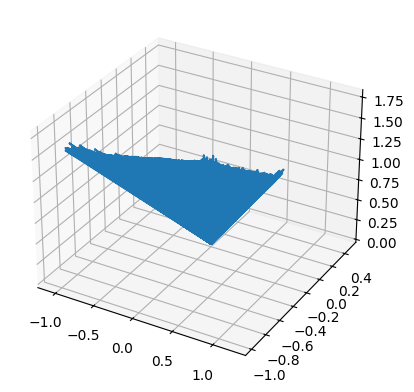

In [192]:
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111, projection='3d')

xs = []
ys = []
zs = []

for i in range(point_cloud.shape[0]):
    for j in range(point_cloud.shape[1]):
        #plt.imshow(point_cloud[i][j])
        xs.append(point_cloud[i][j][0])
        ys.append(point_cloud[i][j][1])
        zs.append(point_cloud[i][j][2])

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(xs,ys,zs)

plt.show()

In [179]:
len(point_cloud[inliers])

805

Filters

In [137]:
def morphological_filter(mask_image, kernel_size=(5, 5), operation='opening'):
    # Define the structuring element (kernel)
    kernel = np.ones(kernel_size, np.uint8)
    mask_image = mask_image.astype('uint8')

    if operation == 'opening':
        # Apply opening operation
        filtered_image = cv2.morphologyEx(mask_image, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        # Apply closing operation
        filtered_image = cv2.morphologyEx(mask_image, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Invalid morphological operation")

    return filtered_image

box detection

In [87]:
def ransac_box_top_detection(point_cloud, threshold, max_iterations):
    # Your RANSAC implementation here
    best_top_model = None
    best_top_inliers = []

    for iteration in range(max_iterations):
        # Randomly sample points from the point cloud (you may need to customize this)
        sample = random_sample(point_cloud, sample_size=3)  # Example: Randomly select 3 points for plane estimation

        # Fit a plane model to the sampled points (you need to implement fit_plane)
        top_model = fit_plane(sample)

        # Calculate inliers using the fitted model and threshold (you need to implement calculate_inliers)
        inliers = calculate_inliers(point_cloud, top_model, threshold)

        # If this model has more inliers, update the best model
        if len(inliers) > len(best_top_inliers):
            best_top_model = top_model
            best_top_inliers = inliers

    # Refine the best model using all inliers (optional)

    return best_top_model, best_top_inliers

In [63]:
def measure_box_dimensions(box_mask, floor_plane, top_plane):
    # Your code to calculate box dimensions here
    height = abs(top_plane[3] - floor_plane[3]) / np.linalg.norm(floor_plane[:3])

    # Find the corners of the box using the mask image
    box_corners = find_box_corners(box_mask)

    # Calculate the length, width, and depth of the box
    length = np.linalg.norm(box_corners[0] - box_corners[1])
    width = np.linalg.norm(box_corners[1] - box_corners[2])
    depth = np.linalg.norm(box_corners[0] - box_corners[3])

    return {
        "height": height,
        "length": length,
        "width": width,
        "depth": depth
    }
    pass

In [186]:
# Floor detection
floor_model = ransac_floor_detection(point_cloud, threshold=0.1, max_iterations=1000)
floor_mask = floor_model['inliers']

sample:  [array([[-0.        , -0.        ,  0.        ],
       [-0.80538583, -0.43677017,  1.14300001],
       [-0.78410029, -0.42692593,  1.11800003],
       ...,
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ]]), array([[-0.        ,  0.        ,  0.        ],
       [-0.50440788,  0.21829511,  0.722     ],
       [-0.50558412,  0.21967848,  0.72700006],
       ...,
       [ 0.54365295,  0.23025692,  0.759     ],
       [ 0.54972142,  0.2319238 ,  0.76400012],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.        ,  0.        ,  0.        ],
       [-0.60678023,  0.01144423,  0.87900001],
       [-0.60479242,  0.01145232,  0.88      ],
       ...,
       [ 0.63146919,  0.01165564,  0.89300001],
       [ 0.63423544,  0.01166128,  0.89300001],
       [ 0.        ,  0.        ,  0.        ]])]


NameError: name 'fit_plane' is not defined

In [138]:
# floor_mask = inliers in In 135

filtered_floor_mask = morphological_filter(inliers)

In [139]:
filtered_floor_mask

array([[  0],
       [  0],
       [  1],
       [  1],
       [  2],
       [  2],
       [  3],
       [  3],
       [  4],
       [  4],
       [  5],
       [  5],
       [  6],
       [  6],
       [  7],
       [  7],
       [  8],
       [  8],
       [  9],
       [  9],
       [ 10],
       [ 10],
       [ 11],
       [ 11],
       [ 12],
       [ 12],
       [ 13],
       [ 13],
       [ 14],
       [ 14],
       [ 15],
       [ 15],
       [ 16],
       [ 16],
       [ 17],
       [ 17],
       [ 18],
       [ 18],
       [ 19],
       [ 19],
       [ 20],
       [ 20],
       [ 21],
       [ 21],
       [ 22],
       [ 22],
       [ 23],
       [ 23],
       [ 24],
       [ 24],
       [ 25],
       [ 25],
       [ 26],
       [ 26],
       [ 27],
       [ 27],
       [ 28],
       [ 28],
       [ 29],
       [ 29],
       [ 30],
       [ 30],
       [ 32],
       [ 35],
       [ 35],
       [ 36],
       [ 36],
       [ 42],
       [ 42],
       [ 43],
       [ 43],
      

In [58]:
# Apply morphological filter to improve floor mask
filtered_floor_mask = morphological_filter(floor_mask)

NameError: name 'floor_mask' is not defined

In [157]:
point_cloud[np.where(inliers == 0)]

array([], shape=(0, 512, 3), dtype=float64)

In [156]:
# Box top detection
# non_floor_points = point_cloud[np.where(filtered_floor_mask == 0)]
non_floor_points = point_cloud[np.where(inliers == 0)]
box_top_model = Plane().fit(non_floor_points)
#box_top_model = ransac_box_top_detection(non_floor_points, threshold=0.1, max_iterations=1000)
box_top_mask = box_top_model['inliers']

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
# Find the largest connected component in the box top mask
components, num_components = label(box_top_mask)
largest_component = np.argmax(np.bincount(components.flat)[1:]) + 1
box_top_mask = np.where(components == largest_component, 1, 0)

In [ ]:
# Measure box dimensions
box_dimensions = measure_box_dimensions(box_top_mask, floor_model, box_top_model)
print("Estimated box dimensions:", box_dimensions)

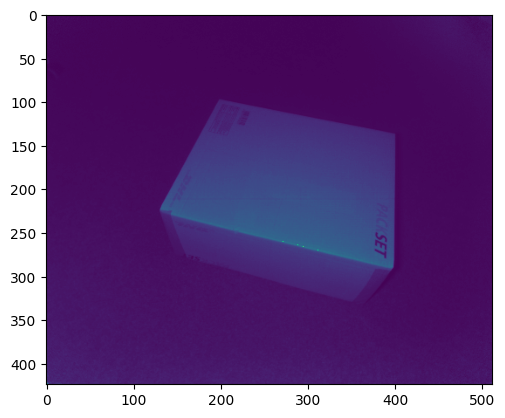

In [169]:
visualise_box(test['amplitudes1'])

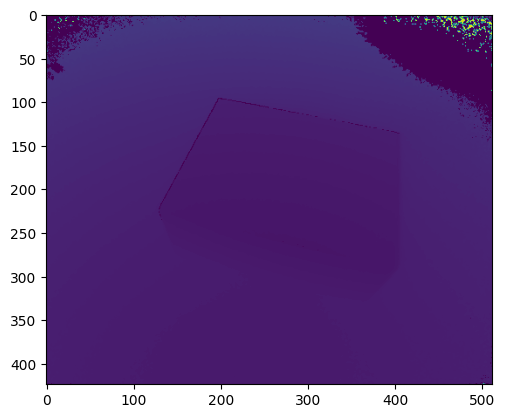

In [170]:
visualise_box(test['distances1'])

In [171]:
len(test['cloud1'])

424

In [173]:
test['cloud1'][0][0]

array([-0., -0.,  0.])

In [164]:
inliers.reshape

array([252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 395, 396, 397,
       398, 399, 403, 404, 405, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 422, 423])

In [166]:
equation

[array([0., 0., 0.]),
 array([ 0.07029368, -0.00212999,  0.0484024 ]),
 array([-0.00227079, -0.00055486, -0.00258115]),
 0.034155217019714704]

In [23]:
test_np = np.array(test)

array({'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Apr 26 16:26:46 2017', '__version__': '1.0', '__globals__': [], 'amplitudes1': array([[    0,  1711,  2618, ..., 11774, 17148,     0],
       [    0,  3487,  3862, ...,  6204,  6588,     0],
       [    0,  2883,  1739, ...,  6702,  7729,     0],
       ...,
       [    0,  9210,  7708, ...,  4909,  4566,     0],
       [    0, 17712, 13374, ...,  9831,  7632,     0],
       [    0, 33642, 16712, ...,  6590,  7424,     0]], dtype=uint16), 'distances1': array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
        0.        ],
       ...,
       [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
        0.        ],
       [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.85190231,
   

In [102]:
test#['amplitudes1']

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Apr 26 16:26:46 2017',
 '__version__': '1.0',
 '__globals__': [],
 'amplitudes1': array([[    0,  1711,  2618, ..., 11774, 17148,     0],
        [    0,  3487,  3862, ...,  6204,  6588,     0],
        [    0,  2883,  1739, ...,  6702,  7729,     0],
        ...,
        [    0,  9210,  7708, ...,  4909,  4566,     0],
        [    0, 17712, 13374, ...,  9831,  7632,     0],
        [    0, 33642, 16712, ...,  6590,  7424,     0]], dtype=uint16),
 'distances1': array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
         0.        ],
        ...,
        [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
         0.        ],
        [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.

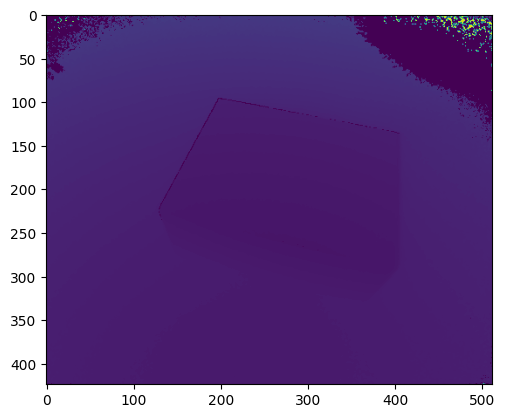

In [38]:
plt.imshow(test['distances1'])